In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_06 import *

## ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)

train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [5]:
nfs = [8, 16, 32, 64, 64]

In [6]:
learn, run = get_learn_run(nfs, data, .4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train: [2.11993578125, tensor(0.3030, device='cuda:0')]
valid: [0.786862255859375, tensor(0.7166, device='cuda:0')]
train: [0.4640348046875, tensor(0.8501, device='cuda:0')]
valid: [0.187003125, tensor(0.9428, device='cuda:0')]
CPU times: user 4.12 s, sys: 1.4 s, total: 5.52 s
Wall time: 16.7 s


## BatchNorm

### Custom

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m, v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return self.mults * x + self.adds

In [9]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [10]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [13]:
learn, run = get_learn_run(nfs, data, .9, conv_layer, cbs=cbfs)

train: [0.27085642578125, tensor(0.9160, device='cuda:0')]
valid: [0.14287445068359375, tensor(0.9569, device='cuda:0')]


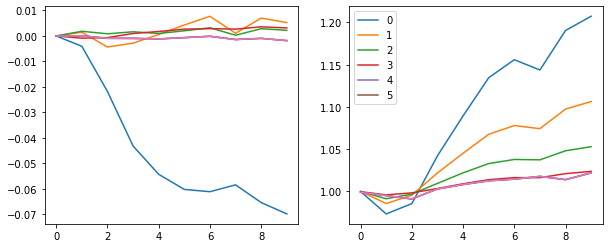

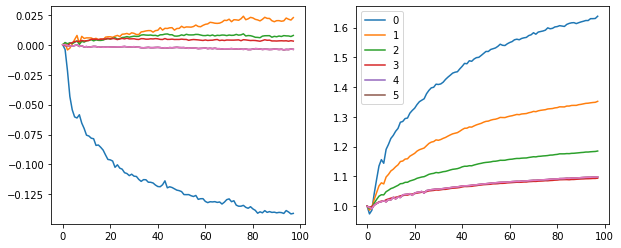

In [14]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        axs[0].plot(ms[:10])
        axs[1].plot(ss[:10])
    plt.legend(range(6))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        axs[0].plot(ms)
        axs[1].plot(ss)
    plt.legend(range(6))

In [15]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [16]:
%time run.fit(3, learn)

train: [0.2585237109375, tensor(0.9214, device='cuda:0')]
valid: [0.1186253662109375, tensor(0.9620, device='cuda:0')]
train: [0.086206318359375, tensor(0.9731, device='cuda:0')]
valid: [0.097247021484375, tensor(0.9700, device='cuda:0')]
train: [0.063735703125, tensor(0.9798, device='cuda:0')]
valid: [0.07375546264648437, tensor(0.9785, device='cuda:0')]
CPU times: user 3.83 s, sys: 536 ms, total: 4.36 s
Wall time: 4.4 s


### Builtin batchnorm

In [17]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=.1))
    return nn.Sequential(*layers)

In [18]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [19]:
%time run.fit(3, learn)

train: [0.2725761328125, tensor(0.9164, device='cuda:0')]
valid: [0.0854400390625, tensor(0.9755, device='cuda:0')]
train: [0.0718575, tensor(0.9775, device='cuda:0')]
valid: [0.07336637573242187, tensor(0.9794, device='cuda:0')]
train: [0.0506936962890625, tensor(0.9840, device='cuda:0')]
valid: [0.052446173095703125, tensor(0.9852, device='cuda:0')]
CPU times: user 3.53 s, sys: 524 ms, total: 4.06 s
Wall time: 4.09 s


### With scheduler

In [20]:
sched = combine_scheds([0.3, 0.7], [sched_lin(.6, 2.), sched_lin(2., .1)])

In [22]:
learn, run = get_learn_run(nfs, data, .9, conv_layer, 
                           cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [23]:
run.fit(8, learn)

train: [0.31442888671875, tensor(0.9096, device='cuda:0')]
valid: [0.092862109375, tensor(0.9736, device='cuda:0')]
train: [0.08299490234375, tensor(0.9743, device='cuda:0')]
valid: [0.2057450439453125, tensor(0.9394, device='cuda:0')]
train: [0.0606349560546875, tensor(0.9807, device='cuda:0')]
valid: [0.0744750244140625, tensor(0.9777, device='cuda:0')]
train: [0.03880637451171875, tensor(0.9874, device='cuda:0')]
valid: [0.0648455078125, tensor(0.9808, device='cuda:0')]
train: [0.0245541455078125, tensor(0.9925, device='cuda:0')]
valid: [0.04879796142578125, tensor(0.9860, device='cuda:0')]
train: [0.016401634521484375, tensor(0.9954, device='cuda:0')]
valid: [0.042227093505859375, tensor(0.9870, device='cuda:0')]
train: [0.010079569702148437, tensor(0.9976, device='cuda:0')]
valid: [0.04105538940429688, tensor(0.9878, device='cuda:0')]
train: [0.006779047241210937, tensor(0.9989, device='cuda:0')]
valid: [0.040585983276367185, tensor(0.9879, device='cuda:0')]


## More norms

### Layer norm

In [31]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var((1, 2, 3), keepdim=True)
        x = (x - m) / (v + self.eps).sqrt()
        return self.mult * x + self.add

In [32]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [33]:
learn, run = get_learn_run(nfs, data, .8, conv_ln, cbs=cbfs)

In [34]:
%time run.fit(3, learn)

train: [nan, tensor(0.1151, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.46 s, sys: 680 ms, total: 5.14 s
Wall time: 5.18 s


### Instance norm

In [35]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        
    def forward(self, x):
        m = x.mean((2, 3), keepdim=True)
        v = x.var((2, 3), keepdim=True)
        x = (x - m) / (v + self.eps).sqrt()
        return self.mults * x  + self.adds

In [36]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [37]:
learn, run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [38]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.3 s, sys: 648 ms, total: 4.95 s
Wall time: 4.99 s


## Fix small batches

In [39]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [40]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=.1))
    return nn.Sequential(*layers)

In [41]:
learn, run = get_learn_run(nfs, data, .4, conv_layer, cbs=cbfs)

In [42]:
%time run.fit(1, learn)

train: [2.3194046875, tensor(0.1892, device='cuda:0')]
valid: [116776875987252.02, tensor(0.2590, device='cuda:0')]
CPU times: user 1min 15s, sys: 2.05 s, total: 1min 17s
Wall time: 1min 19s


### Running Batch Norm

In [52]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [60]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

### Simplified RunningBatchNorm

In [64]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = s.new_tensor(x.numel() / nc)
        mom1 = s.new_tensor(1 - (1-self.mom)/math.sqrt(bs - 1))
        self.sums.lerp_(s, mom1)
        self.sqrs.lerp_(ss, mom1)
        self.count.lerp_(c, mom1)
        self.batch += bs
        means = self.sums / self.count
        varns = (self.sqrs/self.count).sub_(means*means)
        if bool(self.batch < 20): varns.clamp_min_(.01)
        self.factor = self.mults / (varns + self.eps).sqrt()
        self.offset = self.adds - self.factor * means
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        return self.factor * x + self.offset

In [65]:
learn, run = get_learn_run(nfs, data, .8, conv_rbn, 
                           cbs=cbfs+[partial(ParamScheduler, 'lr', sched_lin(1., .2))])

In [66]:
%time run.fit(1, learn)

train: [0.1691087109375, tensor(0.9470, device='cuda:0')]
valid: [0.097046484375, tensor(0.9817, device='cuda:0')]
CPU times: user 11.1 s, sys: 120 ms, total: 11.2 s
Wall time: 11.4 s
